In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import numpy as np
import random
from collections import defaultdict
import os

In [2]:
compile_cmd = "make all"
subprocess.run(compile_cmd, shell=True, check=True)
dir_cmd = "make dirs"
subprocess.run(dir_cmd, shell=True, check=True)

g++ -std=c++17 -O2 -Wall fhn.cpp -o fhn
mkdir -p data plots data/fhn plots/fhn data/linard plots/linard


CompletedProcess(args='make dirs', returncode=0)

In [3]:
np.random.seed(42)
random.seed(42)
stabilizing_time = 100000
window_size = 1
precision_degree = 6
num_params = 101

## Helper Functions
---

In [10]:
def AppendLocalOptima(csv_path, stabilizing_time, window_size, col_string):
    df = pd.read_csv(csv_path)
    df = df.iloc[stabilizing_time:]

    rolling_max = df[col_string].rolling(2 * window_size+ 1, center=True).max()
    rolling_min = df[col_string].rolling(2 * window_size+ 1, center=True).min()

    df['is_local_opt'] = (df[col_string] == rolling_max) | (df[col_string] == rolling_min)
    return df



In [11]:

def PlotExtrema(df, a, col_string1, col_string2, model, initial_conds="./"): 
    plt.figure(figsize=(12, 6))

    mean_u = df[col_string1].mean()
    std_u = df[col_string1].std()

    plt.subplot(2, 1, 1)
    plt.plot(df['time'], df[col_string1], label=col_string1+'(t)')
    plt.title(f'{col_string1} trajectory over time, A = {a}')
    plt.xlabel('Time')
    plt.ylabel(col_string1)

    # Plot local optima
    plt.scatter(
        df.loc[df['is_local_opt'], 'time'],
        df.loc[df['is_local_opt'], col_string1],
        color='red', marker='o', label='Local Optima', zorder=3
    )

    # Plot mean and ±6 std lines
    plt.axhline(mean_u, color='green', linestyle='--', label='Mean')
    plt.axhline(mean_u + 6 * std_u, color='orange', linestyle='--', label='Mean ± 6σ')
    plt.axhline(mean_u - 6 * std_u, color='orange', linestyle='--')

    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(df['time'], df[col_string2], label = col_string2 + '(t)')
    plt.title(f'{col_string2} trajectory over time, A = {a}')
    plt.xlabel('Time')
    plt.ylabel(col_string2)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'plots/{model}/{initial_conds}/extrema_{a}.png')
    plt.close()
    return


In [12]:

def process_timeseries(A, timeseries_dataframes, col_string1, col_string2, model, initial_conds="./", mode='all', n=None, subset=None):

    """
    Parameters:
    - A: list of identifiers (same length as timeseries_dataframes)
    - timeseries_dataframes: list of DataFrames corresponding to A
    - mode: 'all', 'random', or 'subset'
    - n: number of samples to select (used if mode == 'random')
    - subset: list of values to use from A (used if mode == 'subset')
    """

    # Convert to list of tuples for easier handling
    data_pairs = list(zip(A, timeseries_dataframes))

    if mode == 'all':
        selected = data_pairs

    elif mode == 'random':
        if n is None:
            raise ValueError("You must specify 'n' when using mode='random'")
        if n > len(A):
            raise ValueError(f"n={n} is greater than number of available elements={len(A)}")
        selected = random.sample(data_pairs, n)

    elif mode == 'subset':
        if subset is None:
            raise ValueError("You must provide a subset list when using mode='subset'")
        # Keep only those entries where a ∈ subset
        selected = [pair for pair in data_pairs if pair[0] in subset]

    else:
        raise ValueError("mode must be one of: 'all', 'random', or 'subset'")

    for a, df in selected:
        PlotExtrema(df, a, col_string1, col_string2, model, initial_conds=initial_conds)



In [25]:

def bifurcationdiagram(timeseries_dataframes, col="u", model="fhn", initial_conds="./"):
    all_peak_data = []
    stats_data = []
    
    for a, df in timeseries_dataframes.items():
        # Extract local optima for this 'a'
        peak_values = df[col][df["is_local_opt"]]
        for val in peak_values:
            all_peak_data.append({'A': a, 'u_peak': val})
        
        # Calculate statistics for this 'a'
        if len(peak_values) > 0:
            mean_val = peak_values.mean()
            std_val = peak_values.std()
            stats_data.append({
                'A': a, 
                'mean': mean_val, 
                'std': std_val,
                'upper_4std': mean_val + 4 * std_val,
            })

    # Convert to DataFrames
    peak_df = pd.DataFrame(all_peak_data)
    stats_df = pd.DataFrame(stats_data)

    # Plot
    plt.figure(figsize=(8, 6))
    
    # Plot scatter points
    for a in sorted(peak_df['A'].unique()):
        peaks = peak_df[peak_df['A'] == a]['u_peak']
        x_vals = [a] * len(peaks)
        plt.scatter(x_vals, peaks, alpha=0.1, s=1, color='black')

    # Plot mean and ±4σ lines
    if len(stats_df) > 0:
        plt.plot(stats_df['A'], stats_df['mean'], 'r-', linewidth=2, label='Mean')
        plt.plot(stats_df['A'], stats_df['upper_4std'], 'g--', linewidth=1, label='Mean + 4σ')
        # plt.plot(stats_df['A'], stats_df['lower_4std'], 'g--', linewidth=1, label='Mean - 4σ')

    plt.xlabel("Parameter value")
    plt.ylabel("Local optima of a")
    plt.title("Bifurcation Diagram for Timeseries")
    plt.grid(True)
    plt.legend()
    plt.savefig(f'plots/{model}/{initial_conds}/bifurcation.png')
    plt.close()

    return all_peak_data 

In [26]:
def bifurcation_smoothed(peak_data, model="fhn"):
    """
    Create a smoothed bifurcation diagram showing:
    1. Scatter plot from one time series realization
    2. Mean and mean+4σ lines for that specific time series
    3. Shaded regions showing statistics across all realizations
    """
    
    # Select the first realization for detailed plotting
    first_key = list(peak_data.keys())[0]
    selected_realization = peak_data[first_key]
    
    # Convert selected realization data to DataFrame for easier handling
    selected_df = pd.DataFrame(selected_realization)
    
    # Collect statistics from all realizations
    all_stats = []
    all_a_values = set()
    
    for (u0, v0), realization_data in peak_data.items():
        realization_df = pd.DataFrame(realization_data)
        
        # Group by parameter value A and calculate statistics
        for a in realization_df['A'].unique():
            peaks = realization_df[realization_df['A'] == a]['u_peak']
            if len(peaks) > 0:
                mean_val = peaks.mean()
                std_val = peaks.std()
                all_stats.append({
                    'A': a,
                    'u0': u0,
                    'v0': v0, 
                    'mean': mean_val,
                    'std': std_val,
                    'upper_4std': mean_val + 4 * std_val
                })
                all_a_values.add(a)
    
    # Convert to DataFrame
    all_stats_df = pd.DataFrame(all_stats)
    
    # Calculate overall statistics across all realizations for each A
    overall_stats = []
    for a in sorted(all_a_values):
        a_data = all_stats_df[all_stats_df['A'] == a]
        if len(a_data) > 0:
            overall_mean = a_data['mean'].mean()
            overall_upper = a_data['upper_4std'].mean()
            
            # Calculate min and max for mean and mean+4sd across realizations
            mean_min = a_data['mean'].min()
            mean_max = a_data['mean'].max()
            upper_4std_min = a_data['upper_4std'].min()
            upper_4std_max = a_data['upper_4std'].max()
            
            overall_stats.append({
                'A': a,
                'overall_mean': overall_mean,
                'overall_upper': overall_upper,
                'mean_min': mean_min,
                'mean_max': mean_max,
                'upper_4std_min': upper_4std_min,
                'upper_4std_max': upper_4std_max
            })
    
    overall_stats_df = pd.DataFrame(overall_stats)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # 1. Plot scatter points from selected realization (black, low opacity, small size)
    for a in sorted(selected_df['A'].unique()):
        peaks = selected_df[selected_df['A'] == a]['u_peak']
        x_vals = [a] * len(peaks)
        plt.scatter(x_vals, peaks, color='black', alpha=0.1, s=1, 
                   label='Selected realization' if a == sorted(selected_df['A'].unique())[0] else "")
    
    # 2. Calculate and plot mean and mean+4σ for selected realization
    selected_stats = []
    for a in sorted(selected_df['A'].unique()):
        peaks = selected_df[selected_df['A'] == a]['u_peak']
        if len(peaks) > 0:
            mean_val = peaks.mean()
            std_val = peaks.std()
            selected_stats.append({
                'A': a,
                'mean': mean_val,
                'upper_4std': mean_val + 4 * std_val
            })
    
    selected_stats_df = pd.DataFrame(selected_stats)
    
    # # Plot lines for selected realization
    # if len(selected_stats_df) > 0:
    #     plt.plot(selected_stats_df['A'], selected_stats_df['mean'], 
    #             'r-', linewidth=2, label=f'Mean (u0={first_key[0]}, v0={first_key[1]})')
    #     plt.plot(selected_stats_df['A'], selected_stats_df['upper_4std'], 
    #             'g-', linewidth=2, label=f'Mean + 4σ (u0={first_key[0]}, v0={first_key[1]})')
    
    # 3. Plot shaded regions for min-max ranges across all realizations
    if len(overall_stats_df) > 0:
        # Shaded region for mean (min to max across realizations)
        plt.fill_between(overall_stats_df['A'], 
                        overall_stats_df['mean_min'],
                        overall_stats_df['mean_max'],
                        color='red', alpha=0.2, label='Mean range (all realizations)')
        
        # Shaded region for mean + 4σ (min to max across realizations)
        plt.fill_between(overall_stats_df['A'],
                        overall_stats_df['upper_4std_min'],
                        overall_stats_df['upper_4std_max'],
                        color='green', alpha=0.2, label='Mean + 4σ range (all realizations)')
        
        # Plot mean lines for all realizations
        plt.plot(overall_stats_df['A'], overall_stats_df['overall_mean'],
                'r--', linewidth=1, alpha=0.7, label='Overall mean (all realizations)')
        plt.plot(overall_stats_df['A'], overall_stats_df['overall_upper'],
                'g--', linewidth=1, alpha=0.7, label='Overall mean + 4σ (all realizations)')
    
    plt.xlabel("Parameter value (A)")
    plt.ylabel("Local optima")
    plt.title("Smoothed Bifurcation Diagram")
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'plots/{model}/bifurcation_smoothed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return overall_stats_df

In [15]:

def plotGraphMetrics(x, y, model='linard'):
    for x0, y0 in zip(x, y):
        subprocess.run(f"./swap_uv.sh data/{model}/{x0}_{y0}", shell=True, check=True)
        command = f"./graph_characteristics data/{model}/{x0}_{y0}/"
        subprocess.run(command, shell=True, check=True)
        
        # Read the generated graph metrics file
        graph_metrics = pd.read_csv(f'data/{model}/{x0}_{y0}/graph_metrics.csv')

        # Sort by parameter column
        graph_metrics = graph_metrics.sort_values('parameter')

        # Convert parameter column to numeric for proper plotting
        graph_metrics['parameter'] = pd.to_numeric(graph_metrics['parameter'])

        # Create line plots
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(graph_metrics['parameter'], graph_metrics['max_degree'], marker='o', markersize=3)
        plt.xlabel('Parameter')
        plt.ylabel('Max Degree')
        plt.title(f'Parameter vs Max Degree (x0={x0:.6f}, y0={y0:.6f})')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(graph_metrics['parameter'], graph_metrics['avg_degree'], marker='o', markersize=3)
        plt.xlabel('Parameter')
        plt.ylabel('Average Degree')
        plt.title(f'Parameter vs Average Degree (x0={x0:.6f}, y0={y0:.6f})')
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f'plots/{model}/{x0}_{y0}/graph_metrics.png')

        subprocess.run(f"./swap_uv.sh data/{model}/{x0}_{y0}", shell=True, check=True)

# FHN Model
---

In [ ]:
u = np.random.random(size=5)*0.001 + -0.2
v = np.random.random(size = 5)*0.0001 + -0.002
u = np.round(u, precision_degree)
v = np.round(v, precision_degree)
print(f"u values: {u}")
print(f"v values: {v}")

u values: [-0.199625 -0.199049 -0.199268 -0.199401 -0.199844]
v values: [-0.001984 -0.001994 -0.001913 -0.00194  -0.001929]


In [7]:
A = np.round(np.linspace(0.62, 0.63, num_params), precision_degree) 
 

print(A)

csv_paths_fhn = defaultdict(list)
    
for u0, v0 in zip(u, v):
    csv_paths_fhn[(u0, v0)] = {
        a: f"data/fhn/{u0}_{v0}/output_{a}.csv"
        for a in A
    }

print(csv_paths_fhn.items())


[0.62   0.6201 0.6202 0.6203 0.6204 0.6205 0.6206 0.6207 0.6208 0.6209
 0.621  0.6211 0.6212 0.6213 0.6214 0.6215 0.6216 0.6217 0.6218 0.6219
 0.622  0.6221 0.6222 0.6223 0.6224 0.6225 0.6226 0.6227 0.6228 0.6229
 0.623  0.6231 0.6232 0.6233 0.6234 0.6235 0.6236 0.6237 0.6238 0.6239
 0.624  0.6241 0.6242 0.6243 0.6244 0.6245 0.6246 0.6247 0.6248 0.6249
 0.625  0.6251 0.6252 0.6253 0.6254 0.6255 0.6256 0.6257 0.6258 0.6259
 0.626  0.6261 0.6262 0.6263 0.6264 0.6265 0.6266 0.6267 0.6268 0.6269
 0.627  0.6271 0.6272 0.6273 0.6274 0.6275 0.6276 0.6277 0.6278 0.6279
 0.628  0.6281 0.6282 0.6283 0.6284 0.6285 0.6286 0.6287 0.6288 0.6289
 0.629  0.6291 0.6292 0.6293 0.6294 0.6295 0.6296 0.6297 0.6298 0.6299
 0.63  ]
dict_items([((-0.199625, -0.001984), {0.62: 'data/fhn/-0.199625_-0.001984/output_0.62.csv', 0.6201: 'data/fhn/-0.199625_-0.001984/output_0.6201.csv', 0.6202: 'data/fhn/-0.199625_-0.001984/output_0.6202.csv', 0.6203: 'data/fhn/-0.199625_-0.001984/output_0.6203.csv', 0.6204: 'data/f

In [8]:
for u0, v0 in zip(u, v):
    make_initial_cond_dir = f"mkdir -p -- data/fhn/{u0}_{v0}"
    print(make_initial_cond_dir)
    subprocess.run(make_initial_cond_dir, shell=True)
    for a in A:
        subprocess.run(f"./fhn {a} {u0} {v0}", shell=True, check=True)
    

mkdir -p -- data/fhn/-0.199625_-0.001984
mkdir -p -- data/fhn/-0.199049_-0.001994
mkdir -p -- data/fhn/-0.199268_-0.001913
mkdir -p -- data/fhn/-0.199401_-0.00194
mkdir -p -- data/fhn/-0.199844_-0.001929


In [16]:
fhn_dataframes = defaultdict(dict)

for (u0, v0), a_paths in csv_paths_fhn.items():
    for a, path in a_paths.items():
        fhn_dataframes[(u0, v0)][a] = AppendLocalOptima(
            path, stabilizing_time, window_size, 'u'
        )

# print(fhn_dataframes.values())


In [17]:

for (u0, v0) in zip(u, v):
    # Sort dataframes by A values (keys)
    sorted_items = sorted(fhn_dataframes[(u0, v0)].items())
    # print([(a, df) for a, df in sorted_items]) 
    dataframes_list = [df for a, df in sorted_items]
    print(f"Number of dataframes for u0={u0:.6f}, v0={v0:.6f}: {len(dataframes_list)}")
    
    make_initial_cond_dir = f"mkdir -p -- plots/fhn/{u0}_{v0}"
    print(make_initial_cond_dir)
    subprocess.run(make_initial_cond_dir, shell=True)
    process_timeseries(A, dataframes_list, 'u', 'v', 'fhn', mode='all', initial_conds=f"./{u0}_{v0}")


Number of dataframes for u0=-0.199625, v0=-0.001984: 101
mkdir -p -- plots/fhn/-0.199625_-0.001984
Number of dataframes for u0=-0.199049, v0=-0.001994: 101
mkdir -p -- plots/fhn/-0.199049_-0.001994
Number of dataframes for u0=-0.199268, v0=-0.001913: 101
mkdir -p -- plots/fhn/-0.199268_-0.001913
Number of dataframes for u0=-0.199401, v0=-0.001940: 101
mkdir -p -- plots/fhn/-0.199401_-0.00194
Number of dataframes for u0=-0.199844, v0=-0.001929: 101
mkdir -p -- plots/fhn/-0.199844_-0.001929


Initial conditions: u0 = -0.199625, v0 = -0.001984
Initial conditions: u0 = -0.199049, v0 = -0.001994
Initial conditions: u0 = -0.199268, v0 = -0.001913
Initial conditions: u0 = -0.199401, v0 = -0.00194
Initial conditions: u0 = -0.199844, v0 = -0.001929


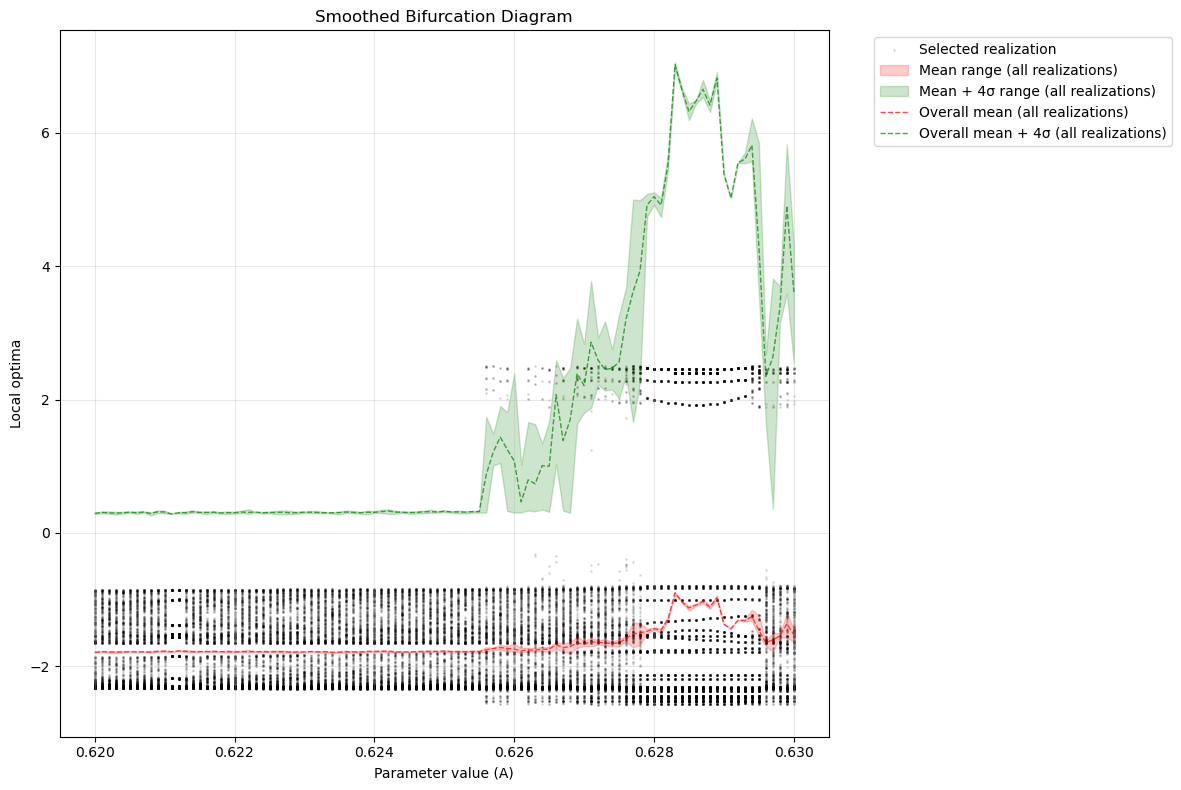

,A,overall_mean,overall_upper,mean_min,mean_max,upper_4std_min,upper_4std_max
0,0.6200,-1.787128,0.294068,-1.791634,-1.780621,0.284734,0.304189
1,0.6201,-1.778970,0.309560,-1.782042,-1.770909,0.292101,0.320814
2,0.6202,-1.780335,0.301679,-1.792440,-1.775321,0.290819,0.324509
3,0.6203,-1.785112,0.296681,-1.802056,-1.772019,0.275348,0.317788
4,0.6204,-1.781645,0.302427,-1.788941,-1.772494,0.288419,0.315351
...,...,...,...,...,...,...,...
96,0.6296,-1.645579,2.346867,-1.697009,-1.619095,1.629455,2.694510
97,0.6297,-1.601410,2.636514,-1.776100,-1.490598,0.367234,3.810735
98,0.6298,-1.542167,3.371718,-1.571088,-1.504710,3.143248,3.694359
99,0.6299,-1.360500,4.902857,-1.562519,-1.204360,3.593026,5.826209


In [27]:
peak_data = {} 
for (u0, v0) in zip(u, v):
    print(f"Initial conditions: u0 = {u0}, v0 = {v0}")
    peak_data[u0, v0] = bifurcationdiagram(fhn_dataframes[(u0, v0)], initial_conds=f"./{u0}_{v0}", model="fhn")

bifurcation_smoothed(peak_data)

Processed data/fhn/-0.199388_-0.001921/output_0.6201.csv
Processed data/fhn/-0.199388_-0.001921/output_0.6202.csv
Processed data/fhn/-0.199388_-0.001921/output_0.6203.csv
Processed data/fhn/-0.199388_-0.001921/output_0.6204.csv
Processed data/fhn/-0.199388_-0.001921/output_0.6205.csv
Processed data/fhn/-0.199388_-0.001921/output_0.6206.csv
Processed data/fhn/-0.199388_-0.001921/output_0.6207.csv
Processed data/fhn/-0.199388_-0.001921/output_0.6208.csv
Processed data/fhn/-0.199388_-0.001921/output_0.6209.csv
Processed data/fhn/-0.199388_-0.001921/output_0.6211.csv
Processed data/fhn/-0.199388_-0.001921/output_0.6212.csv
Processed data/fhn/-0.199388_-0.001921/output_0.6213.csv
Processed data/fhn/-0.199388_-0.001921/output_0.6214.csv
Processed data/fhn/-0.199388_-0.001921/output_0.6215.csv
Processed data/fhn/-0.199388_-0.001921/output_0.6216.csv
Processed data/fhn/-0.199388_-0.001921/output_0.6217.csv
Processed data/fhn/-0.199388_-0.001921/output_0.6218.csv
Processed data/fhn/-0.199388_-0

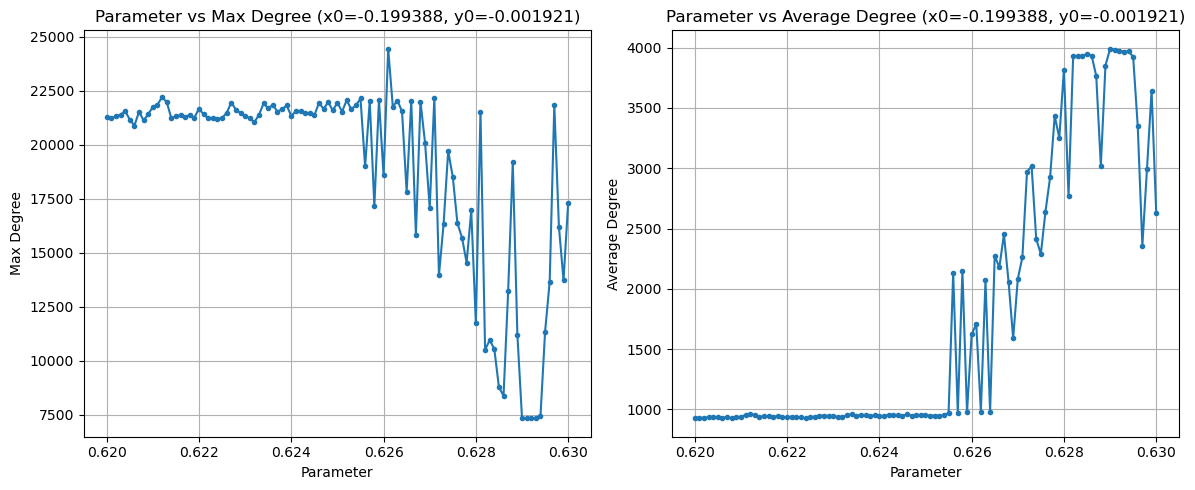

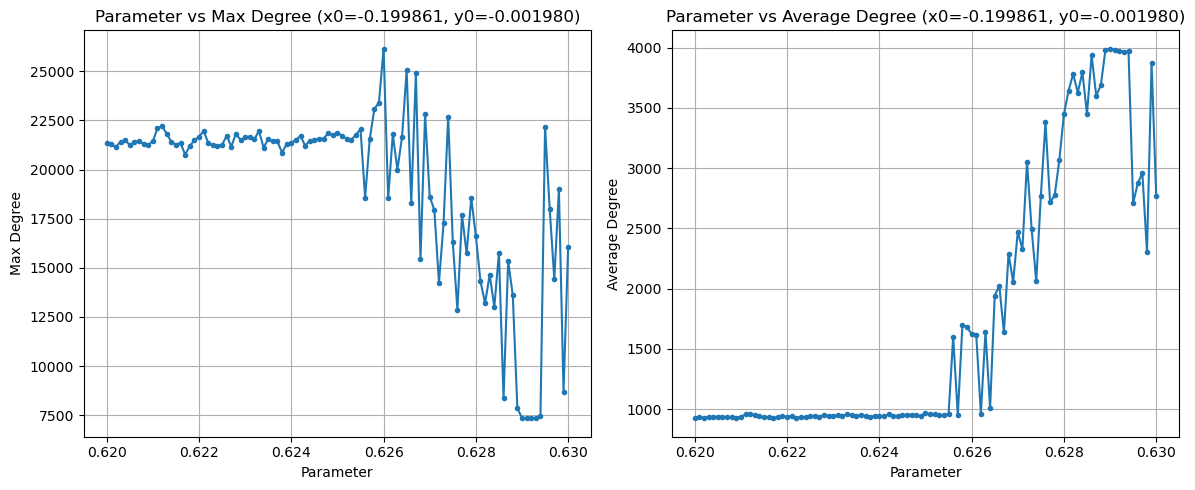

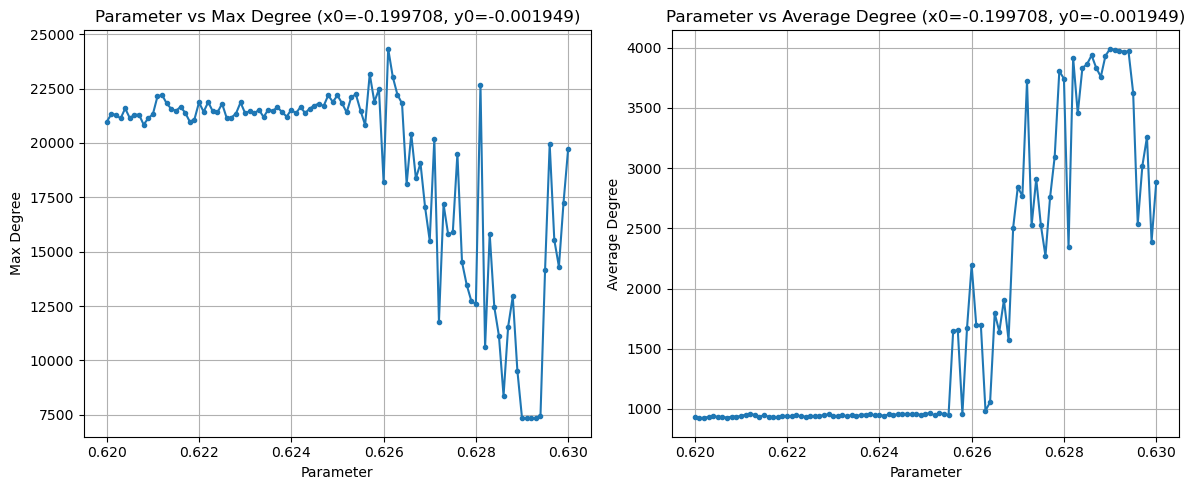

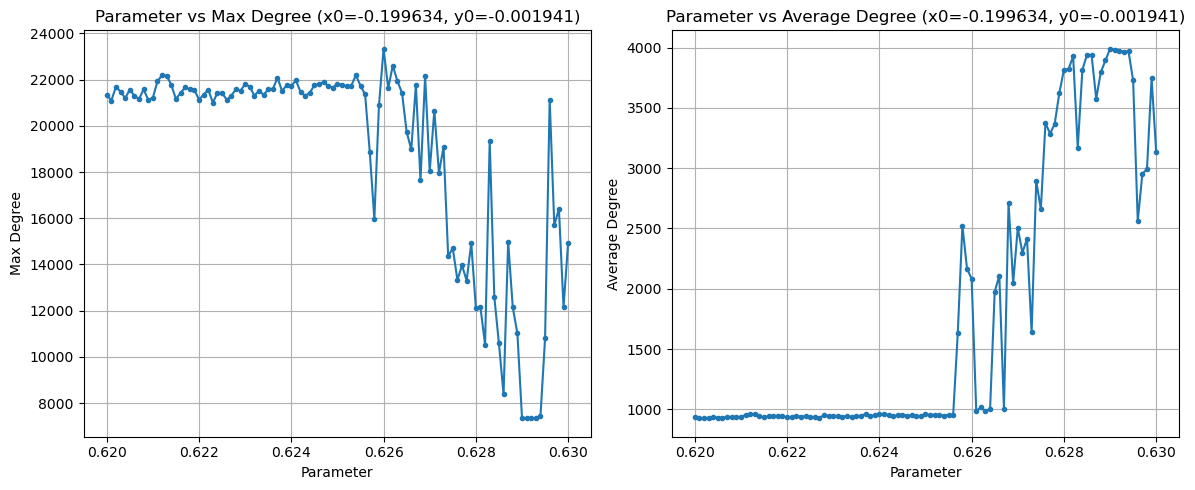

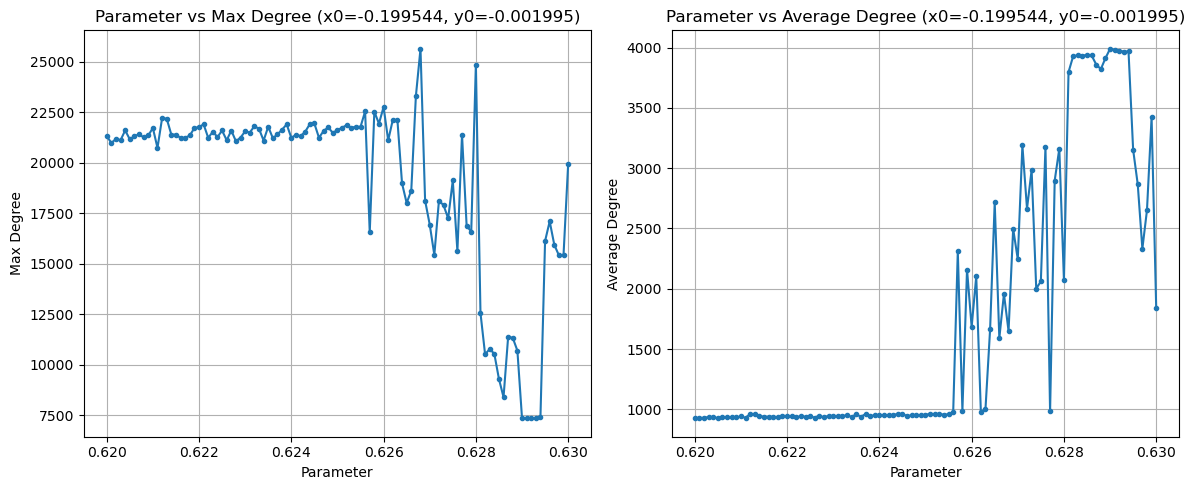

In [18]:
plotGraphMetrics(u, v, "fhn")

# Linard Model
---

In [ ]:
x = np.random.random(size=10) - 0.5
y = np.random.random(size = 10)
x = np.round(x, precision_degree)
y = np.round(y, precision_degree)

In [ ]:

omega_vals = np.round(np.linspace(0.64, 0.74, num_params), precision_degree)

for x0, y0 in zip(x, y):
    make_initial_cond_dir = f"mkdir -p -- data/linard/{x0}_{y0}"
    print(make_initial_cond_dir)
    subprocess.run(make_initial_cond_dir, shell=True)
    for omega in omega_vals:
        subprocess.run(f"./linard {omega} {x0} {y0}", shell=True, check=True)

csv_paths_linard = defaultdict(list)
    
for x0, y0 in zip(x, y):
    csv_paths_linard[(x0, y0)] = {
        omega: f"data/linard/{x0}_{y0}/output_{omega}.csv"
        for omega in omega_vals
    }

print(csv_paths_fhn.items())

In [ ]:
linard_dataframes = defaultdict(dict)

for (x0, y0), omega_paths in csv_paths_linard.items():
    for omega, path in omega_paths.items():
        linard_dataframes[(x0, y0)][omega] = AppendLocalOptima(
            path, stabilizing_time, window_size, 'x'
        )

In [ ]:

for (x0, y0) in zip(x, y):
    # Sort dataframes by A values (keys)
    sorted_items = sorted(linard_dataframes[(x0, y0)].items())
    dataframes_list = [df for omega, df in sorted_items]
    print(f"Number of dataframes for x0={x0:.6f}, y0={y0:.6f}: {len(dataframes_list)}")
    
    make_initial_cond_dir = f"mkdir -p -- plots/linard/{x0}_{y0}"
    subprocess.run(make_initial_cond_dir, shell=True)
    process_timeseries(A, dataframes_list, 'x', 'y', 'linard', mode='all', initial_conds=f"./{x0}_{y0}")

In [ ]:
for (x0, y0) in zip(x, y):
    print(f"Initial conditions: x0 = {x0}, y0 = {y0}")
    bifurcationdiagram(linard_dataframes[(x0, y0)], col = 'x', initial_conds=f"./{x0}_{y0}", model="linard")


In [ ]:

plotGraphMetrics(x, y, "linard")